<a href="https://colab.research.google.com/github/stiflerGit/CAD-Mammography/blob/master/CNN_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for Abnormality detection in mammography

## Computational Intelligence Project 18/19

In [0]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls 'drive/My Drive/CI_FinalProject'

'Copia di FinalProject.ipynb'	      'Copia di train_img_150.npy'
'Copia di public_test_image_150.npy'  'Copia di train_img_224.npy'
'Copia di public_test_image_224.npy'  'Copia di train_img_512.npy'
'Copia di public_test_image_512.npy'  'Copia di train_lab.npy'
'Copia di public_test_label.npy'


In [0]:
# 512 * 512
train_gray_imgs = np.load("/content/drive/My Drive/CI_FinalProject/Copia di train_img_224.npy")
train_rgb_imgs = np.stack((train_gray_imgs,)*3, axis=-1)
train_lbls = np.load("drive/My Drive/CI_FinalProject/Copia di train_lab.npy")

test_gray_imgs = np.load("drive/My Drive/CI_FinalProject/Copia di public_test_image_224.npy")
test_rgb_imgs = np.stack((test_gray_imgs,)*3, axis=-1)
test_lbls = np.load("drive/My Drive/CI_FinalProject/Copia di public_test_label.npy")

print(train_gray_imgs.shape) # 2864 images: it is a small data set
print(train_gray_imgs.dtype)

(2864, 224, 224)
uint16


TrainSet is too big, it will give **ResourceExhaustedError** later.

Trying to use generator instead.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator?
train_datagen = ImageDataGenerator(featurewise_center = True, samplewise_center= True, featurewise_std_normalization= True, rescale=1./65536, horizontal_flip=True, vertical_flip=True)
train_iterator = train_datagen.flow(train_rgb_imgs, train_lbls, batch_size=64)

validation_datagen = ImageDataGenerator(featurewise_center = True, samplewise_center= True, featurewise_std_normalization= True, rescale=1./65536, horizontal_flip=True, vertical_flip=True)
validation_iterator = validation_datagen.flow(test_rgb_imgs, test_lbls, batch_size=16)

test_datagen = ImageDataGenerator(featurewise_center = True, samplewise_center= True, featurewise_std_normalization= True, rescale=1./65536, horizontal_flip=True, vertical_flip=True)
test_iterator = validation_datagen.flow(test_rgb_imgs, test_lbls, batch_size=16)

Using TensorFlow backend.


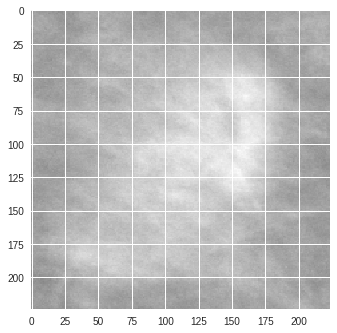

In [0]:
# Input example
import matplotlib.pyplot as plt
from keras.preprocessing import image

img = test_rgb_imgs[10]
plt.figure()

plt.imshow(image.array_to_img(img))

Since our data-set contains only 2864 images we have to deal with a *Small Dataset Problem* . 

Looking only to what we have learned in the lessons we have either 3 way to follow:


1. Data augmentation
2. Feature extraction with pre-trained network
3. Fine-Tuning a pre-trained network

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top = False,
                  input_shape =(224, 224, 3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable
    
        
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

# model.fit?
'''model.fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, 
              callbacks=None, validation_split=0.0, validation_data=None, 
              shuffle=True, class_weight=None, sample_weight=None, 
              initial_epoch=0, steps_per_epoch=None, validation_steps=None, 
              **kwargs)'''
# model.fit_generator?
history = model.fit_generator(train_iterator, steps_per_epoch=45, epochs=15,
                              validation_data=validation_iterator,
                              validation_steps=25)


Epoch 1/15


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


45/45 [==============================] - 46s 1s/step - loss: 0.5559 - acc: 0.7304 - val_loss: 0.4107 - val_acc: 0.8300
Epoch 2/15
45/45 [==============================] - 33s 723ms/step - loss: 0.4256 - acc: 0.8132 - val_loss: 0.3597 - val_acc: 0.8325
Epoch 3/15
45/45 [==============================] - 32s 721ms/step - loss: 0.3622 - acc: 0.8397 - val_loss: 0.3431 - val_acc: 0.8550
Epoch 4/15
45/45 [==============================] - 32s 721ms/step - loss: 0.3282 - acc: 0.8705 - val_loss: 0.3262 - val_acc: 0.8650
Epoch 5/15
45/45 [==============================] - 32s 721ms/step - loss: 0.3095 - acc: 0.8718 - val_loss: 0.3129 - val_acc: 0.8550
Epoch 6/15
45/45 [==============================] - 33s 723ms/step - loss: 0.2901 - acc: 0.8831 - val_loss: 0.3529 - val_acc: 0.8700
Epoch 7/15
45/45 [==============================] - 33s 723ms/step - loss: 0.3028 - acc: 0.8782 - val_loss: 0.3584 - val_acc: 0.8450
Epoch 8/15
45/45 [==============================] - 32s 722ms/step - loss: 0.2840 -

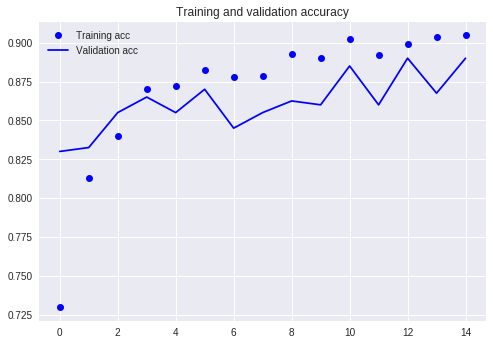

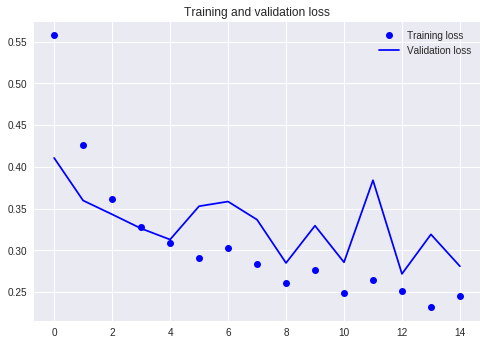

In [0]:
# plot the history
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
test_rgb_imgs = np.stack((test_gray_imgs,)*3, axis=-1)
test_rgb_float_imgs = 1./65536 * test_rgb_imgs

# print(test_rgb_float_imgs)
test_loss, test_acc = model.evaluate(test_rgb_float_imgs, test_lbls)

print(test_loss)
print(test_acc)

352/352 [==============================] - 3s 10ms/step
0.45281118289990857
0.8238636363636364


In [0]:
import os
import pickle

working_dir ="/content/drive/My Drive/My_CI_FinalProject/"
if not os.path.exists(working_dir):
  os.makedirs(working_dir)
model.save(os.path.join(working_dir, '1-fine_tuning_block5.h5'))
# Save the history as a dictionary in case you want to plot the loss 
# or accuracy later on.
# file_pi = os.open(os.path.join(working_dir, '/trainHistoryDict'), 'wb')
# pickle.dump(history.history, file_pi)
# end
